# Simulating the drift diffusion model with stochastic differential equation

We will use the stochastic differential equation to simulate the driftdiffusion model. For details see Tuerlinckx et al. (2001).

$$ \Delta L(t) = L(t+h) - L(t) = x(t+h) = \delta * h + \sqrt h * \epsilon (t+h)$$

Import libraries 

In [63]:
import numpy as np
import matplotlib.pyplot as plt

We need to specify the parameters

In [103]:
h = .01 # the time step
delta = .5 # the drift rate
sigma =1 # the drift coefficient
alpha = 2 # threshold separation...assuming bottom threshold is at 0
beta = .5 # relative startpoint
z = beta*alpha # set the start point based on threshold separation 

In [110]:
i = 0
L = [z] #the accumulated evidence

while L[i] >= 0 and L[i] <= alpha:
    
    i = i+1;
    randomNorm = np.random.randn() # draw from std normal distribution
    evidence = delta*h+(sigma*h**(.5))*randomNorm
    L.append(L[i-1] + evidence) # accumulating evidence

the decision time


In [111]:
decisionTime = i*h

the choice True = Yes; False = No


In [112]:
choice = L[i]>=alpha

plot a trajectory


In [113]:
theTime = [i for i in np.arange(0*h,(i+1)*h,h)] # note that arange(start, stop, step),stop is not included in list

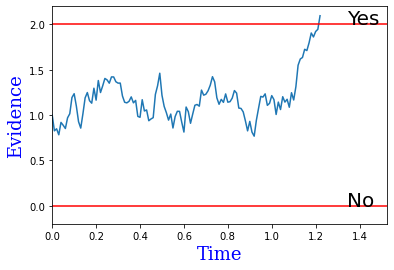

In [127]:
plt.plot(theTime, L)
plt.axhline(y=0, color='r', linestyle='-') # bottom threshold
plt.axhline(y=2, color='r', linestyle='-') # upper threshold
plt.xlim([0,1.25*decisionTime])
plt.ylim([-.20,alpha+.20])
plt.text(1.1*decisionTime,alpha,'Yes', fontsize=20)
plt.text(1.1*decisionTime,0,'No', fontsize=20)

font = {'family':'serif','color':'blue','size':18}
plt.xlabel('Time',fontdict= font)
plt.ylabel('Evidence',fontdict= font)
plt.show()

Note one issue with this simulation approach is that in the final step,
the accumulated evidence ALWAYS overshoots the boundary, and this leads
to inaccuracies in its approximations of the theoretical diffusion
process see Luce (1986) and smith (1990). Heath and Kelly (1988) have an
ad hoc method for correcting by widening the boundaries just a bit. So
that 

$$\alpha \to \alpha + \zeta \sigma \sqrt h $$

$$  0 \to - \zeta \sigma \sqrt h $$

we can get $$ \zeta $$

## Simulate a large number of runs

In [142]:
nd = 500 # number of simulated random walks
reallylargenumber = int(7/(h*delta/sigma))  # to make sure all the simulated random walks will reach a threshold we make sure we generate enough randomnumbers
giantRY = np.random.randn(nd, reallylargenumber) # to generate the evidence samples we will generate a matrix of nd x reallylargenumber
y = delta*h+(sigma*h**.5)*giantRY # this matrix represents the random samples of evidence at each time point that we will accumulate to simulate the drift diffusion process
#y = [np.zeros((nd,1))+z, y] # add a start point
# L = np.cumsum(y, axis=1) # accumulate (cumulative sum) the information across the columns to reprsent Accumulated evidence 

In [143]:
y

array([[-0.03948754,  0.11657289, -0.05023246, ...,  0.06416737,
        -0.02271806, -0.07836509],
       [ 0.03571986, -0.07598161,  0.1124478 , ...,  0.03680023,
         0.0217847 ,  0.05353746],
       [-0.03498462,  0.05101688,  0.16084431, ...,  0.03735654,
         0.01737952, -0.11945181],
       ...,
       [ 0.08293203,  0.08173008,  0.15891003, ...,  0.04047519,
        -0.02265272, -0.03486299],
       [-0.02142248, -0.07238784, -0.16812925, ...,  0.0646062 ,
        -0.09559701,  0.00442617],
       [-0.08070264,  0.14045692,  0.03562452, ..., -0.01437177,
        -0.09556552,  0.00182575]])

In [133]:
np.random.randn(500, 1400)

array([[ 1.00538936,  0.5160567 , -0.47933904, ...,  1.48156902,
        -1.39611854, -0.37594697],
       [ 0.3247866 , -1.88315829,  0.79062528, ..., -0.40339648,
         1.97435497, -2.22561275],
       [ 0.50346704, -0.73423766,  1.92015169, ...,  0.96752782,
        -2.94274886, -1.03573361],
       ...,
       [-0.72226575, -0.0647092 ,  1.44438064, ..., -1.63101541,
         0.42762962,  0.24771413],
       [ 1.19337799,  0.47901859, -0.73801594, ..., -1.90374576,
         0.6096794 , -0.08459691],
       [-0.40700896,  0.88313974,  1.21051932, ...,  1.32422019,
        -0.24786368,  0.44275901]])

In [132]:
nd


500